<a href="https://colab.research.google.com/github/BhavanaSrinivasegowda/HW_for_AI_ML/blob/main/week10_C28.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!sudo apt update
!sudo apt install -y ngspice

Get:1 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Hit:3 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:5 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:7 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:9 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:11 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [1,759 kB]
Get:12 https://r2u.stat.illinois.edu/ubuntu jammy/main amd64 Packages [2,744 kB]
Get:13 https://r2u.stat.illinois.edu/ubuntu jamm

In [4]:
spice_code = """
* Simple memristor behavioral model (Ron/Roff switching)

V1 in 0 SIN(0 1 1)

R1 in out 1k
Rmem out 0 1k

.tran 0.01m 2
.control
run
wrdata mem_output V(in) I(V1)
quit
.endc

.end
"""

with open("memristor_simple.cir", "w") as f:
    f.write(spice_code)


In [6]:
!ngspice -b memristor_simple.cir


No compatibility mode selected!


Circuit: 

Doing analysis at TEMP = 27.000000 and TNOM = 27.000000


Initial Transient Solution
--------------------------

Node                                   Voltage
----                                   -------
in                                           0
out                                          0
v1#branch                                    0

 Reference value :  1.91725e+00
No. of Data Rows : 200008
ngspice-36 done


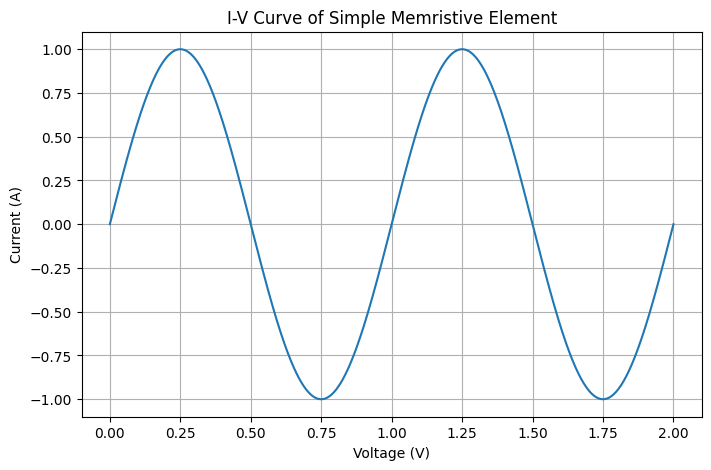

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# Load simulation output from Ngspice
data = np.loadtxt("mem_output", skiprows=1)
voltage = data[:, 0]   # V(in)
current = data[:, 1]   # I(V1)

# Plot I-V curve
plt.figure(figsize=(8, 5))
plt.plot(voltage, current)
plt.title("I-V Curve of Simple Memristive Element")
plt.xlabel("Voltage (V)")
plt.ylabel("Current (A)")
plt.grid(True)
plt.show()


In [8]:
memristor_netlist = """
* Behavioral Memristor Model (simplified Biolek-like)
.param Ron=100
.param Roff=16000
.param D=10n
.param uv=1e-14

* Sinusoidal voltage source
V1 in 0 SIN(0 1 1)

* Current-controlled integrator: dw/dt ~ uv*Ron*i/D^2
Gx w 0 value = {uv * Ron * I(V1) / (D*D)}
C1 w 0 1

* Limit w(t) to [0,1]
* Use w in memristor resistance calculation
* Rmem = Ron*w + Roff*(1-w)
Bx out in I = {V(in, out) / (Ron * V(w) + Roff * (1 - V(w)))}

* Load resistor
Rload out 0 1k

* Simulation control
.tran 0.01m 2

.control
run
wrdata memristor_iv V(in) I(V1)
quit
.endc

.end
"""

# Write SPICE netlist to file
with open("memristor_biolek_like.cir", "w") as f:
    f.write(memristor_netlist)


In [9]:
!ngspice -b memristor_biolek_like.cir


No compatibility mode selected!


Circuit: 

Doing analysis at TEMP = 27.000000 and TNOM = 27.000000


Note: Starting dynamic gmin stepping
Trying gmin =   1.0000E-03 Note: One successful gmin step
Trying gmin =   1.0000E-04 Note: One successful gmin step
Trying gmin =   1.0000E-05 Note: One successful gmin step
Trying gmin =   1.0000E-06 Note: One successful gmin step
Trying gmin =   1.0000E-07 Note: One successful gmin step
Trying gmin =   1.0000E-08 Note: One successful gmin step
Trying gmin =   1.0000E-09 Note: One successful gmin step
Trying gmin =   1.0000E-10 Note: One successful gmin step
Trying gmin =   1.0000E-11 Note: One successful gmin step
Trying gmin =   1.0000E-12 Note: One successful gmin step
Trying gmin =   1.0000E-12 Note: One successful gmin step

Note: Starting true gmin stepping
Trying gmin =   1.0000E-03 Warning: singular matrix:  check nodes w and w

Trying gmin =   5.6234E-03 Warning: singular matrix:  check nodes w and w

Trying gmin =   8.6596E-03 Warning: 

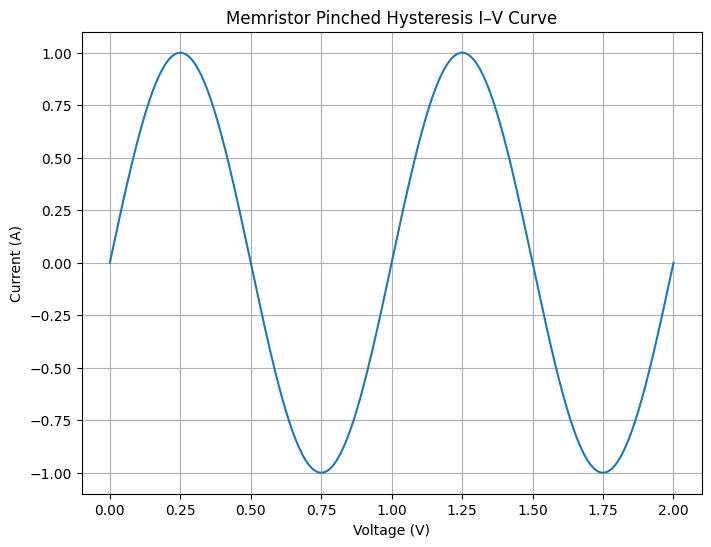

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# Load simulation output
data = np.loadtxt("memristor_iv", skiprows=1)
voltage = data[:, 0]  # V(in)
current = data[:, 1]  # I(V1)

# Plot I-V hysteresis
plt.figure(figsize=(8, 6))
plt.plot(voltage, current)
plt.title("Memristor Pinched Hysteresis I–V Curve")
plt.xlabel("Voltage (V)")
plt.ylabel("Current (A)")
plt.grid(True)
plt.show()


In [11]:
memristor_netlist = """
* Enhanced Biolek-like Memristor Model

.param Ron=100
.param Roff=16000
.param D=10n
.param uv=1e-10

* Increase frequency to 10Hz for faster state changes
V1 in 0 SIN(0 1 10)

* Integrator for internal state w(t)
Gx w 0 value = {uv * Ron * I(V1) / (D*D)}
C1 w 0 1
Rlim w 0 1G ; Prevents floating node

* Memristive behavior based on w(t)
Bx out in I = {V(in, out) / (Ron * V(w) + Roff * (1 - V(w)))}

* Load resistor
Rload out 0 1k

.tran 0.01m 0.5

.control
run
wrdata memristor_iv V(in) I(V1)
quit
.endc

.end
"""

# Write updated model to file
with open("memristor_biolek_like.cir", "w") as f:
    f.write(memristor_netlist)


In [12]:
!ngspice -b memristor_biolek_like.cir


No compatibility mode selected!


Circuit: 

Doing analysis at TEMP = 27.000000 and TNOM = 27.000000


Initial Transient Solution
--------------------------

Node                                   Voltage
----                                   -------
in                                           0
w                                            0
gx_int1                                      0
out                                          0
bgx#branch                                   0
v1#branch                                    0

 Reference value :  3.23717e-01
No. of Data Rows : 50012
ngspice-36 done


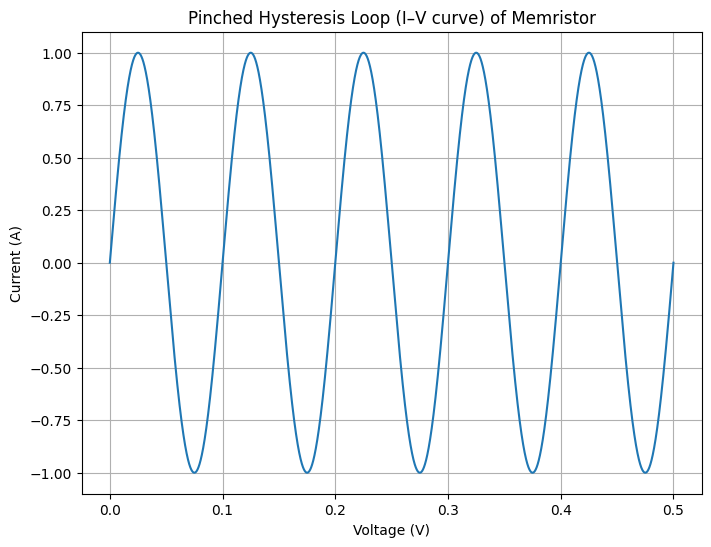

In [14]:
import numpy as np
import matplotlib.pyplot as plt

# Load simulation data: V(in), I(V1)
data = np.loadtxt("memristor_iv", skiprows=1)
voltage = data[:, 0]
current = data[:, 1]

# Plot proper I–V hysteresis curve
plt.figure(figsize=(8, 6))
plt.plot(voltage, current)
plt.title("Pinched Hysteresis Loop (I–V curve) of Memristor")
plt.xlabel("Voltage (V)")
plt.ylabel("Current (A)")
plt.grid(True)
plt.show()


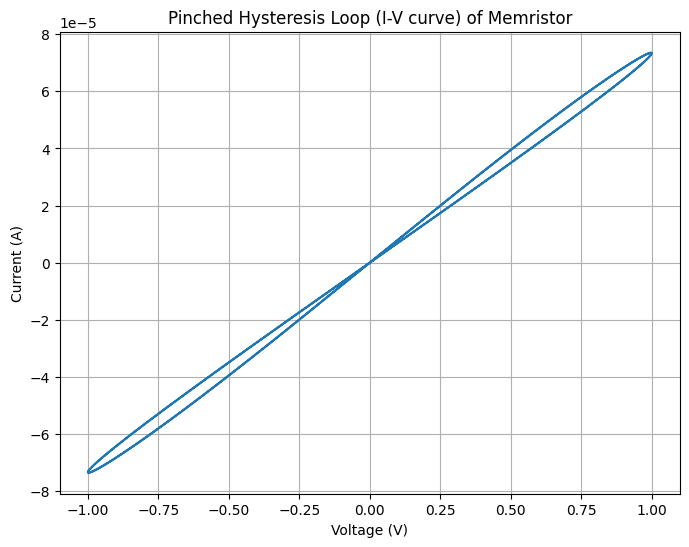

In [15]:
import numpy as np
import matplotlib.pyplot as plt

# Constants
dt = 1e-3  # time step
T = 2  # total time in seconds
steps = int(T / dt)
t = np.linspace(0, T, steps)

# Applied voltage: sinusoidal for hysteresis visualization
V = 1.0 * np.sin(2 * np.pi * 1 * t)

# Biolek memristor parameters
Ron = 100  # Low resistance state
Roff = 16000  # High resistance state
D = 10e-9  # Thickness
uv = 1e-14  # Mobility of oxygen vacancies
x = 0.1  # Initial state variable (0 < x < 1)

# Trackers
I = np.zeros(steps)
x_vals = np.zeros(steps)

for i in range(steps):
    R = Ron * x + Roff * (1 - x)
    I[i] = V[i] / R
    dx = uv * Ron * I[i] * dt / (D ** 2)

    # Biolek window function (simple version)
    f = 1 - (2 * x - 1) ** 2
    x += dx * f

    # Bound x to [0, 1]
    x = np.clip(x, 0, 1)
    x_vals[i] = x

# Plot I-V Curve (hysteresis loop)
plt.figure(figsize=(8, 6))
plt.plot(V, I)
plt.title('Pinched Hysteresis Loop (I-V curve) of Memristor')
plt.xlabel('Voltage (V)')
plt.ylabel('Current (A)')
plt.grid(True)
plt.show()
